# Exploration.12 - 챗봇 만들기

## 기본 개념

### 1. Transformer 구성

![transformer](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_3_ddZedfW.max-800x600.png)

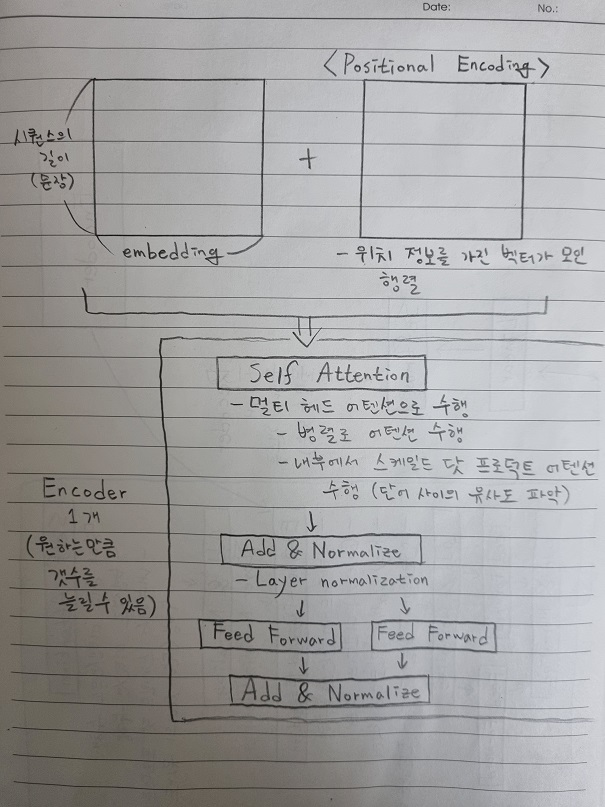

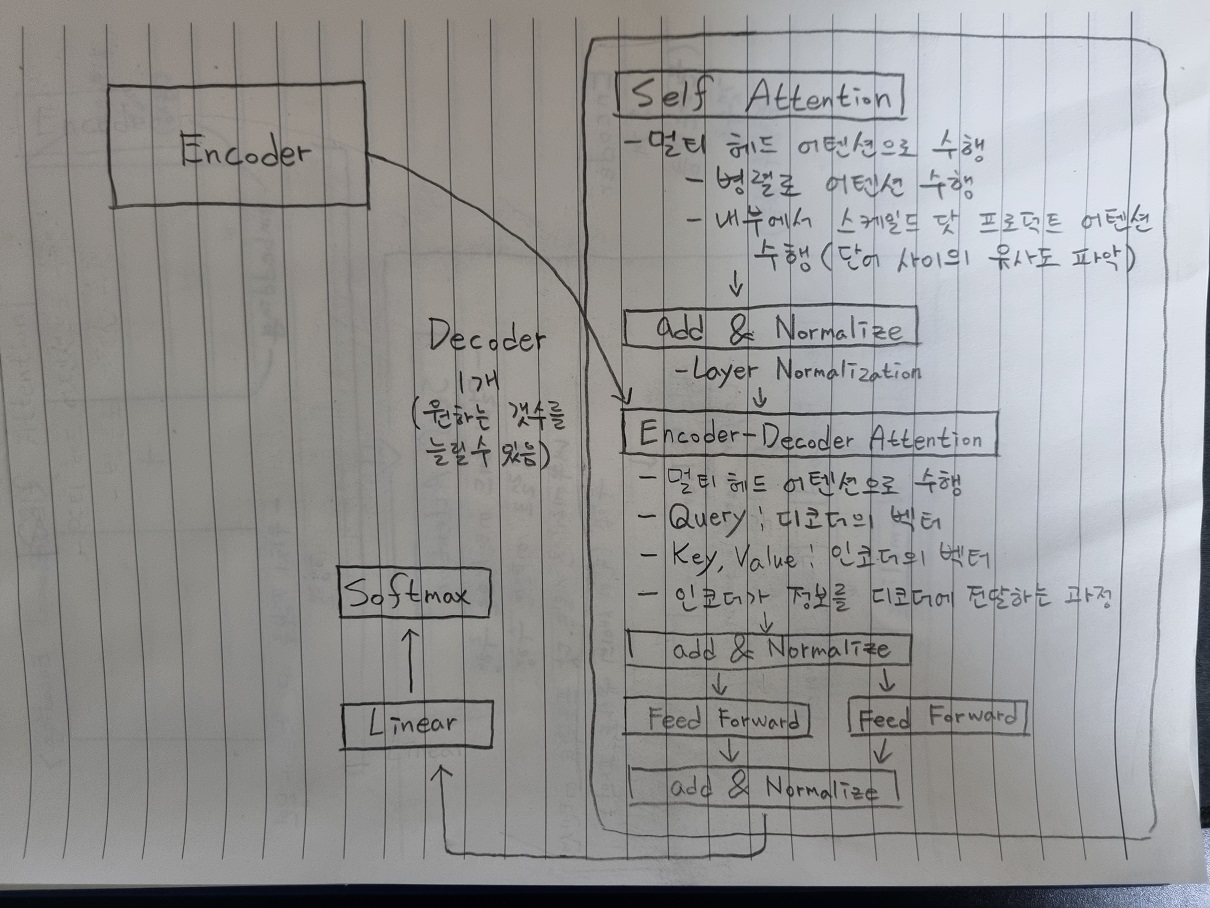

### 2. RNN에 기반한 seq2seq 모델의 단점
    - 하나의 고정된 크기의 벡터에 모든 정보를 압축하려고 하니까 정보 손실이 발생
    - RNN의 고질적인 문제인 기울기 소실(vanishing gradient) 문제가 존재

### 3. RNN 계열 모델과 Transformer의 차이점
- RNN 계열
    - step별로 단어를 순차적으로 입력받음
        - 모델에게 따로 어순 정보를 알려줄 필요가 없음
        - 병렬 처리가 어려움
    
- Transformer
    - Sequence를 한번에 입력받음
        - Attention 등의 구조를 통해 어떤 부분이 중요한지를 전달해야 함 (위치 정보 반영)
        - 병렬 처리가 가능

## import Package

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Positional Encoding
- Transformer의 병렬처리로 인해 각 단어들의 위치를 컴퓨터에게 전달해야 함
- 단어의 상대적인 위치 정보를 제공하기 위한 벡터를 만드는 과정

## 데이터 불러오기

In [2]:
file_path_root = os.path.join(os.getenv('HOME'), 'aiffel')
file_path =  file_path_root + '/transformer_chatbot/data/ChatbotData .csv'
train = pd.read_csv(file_path)

In [3]:
train.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
len(train)

11823

- 데이터는 총 11,823개

## Preprocessing

### 1. 질문과 답변을 나눠 데이터셋 구성
- 현재는 [질문, 답변, 레이블] 구성으로 되어있음

In [5]:
train['Q'].head()

0             12시 땡!
1        1지망 학교 떨어졌어
2       3박4일 놀러가고 싶다
3    3박4일 정도 놀러가고 싶다
4            PPL 심하네
Name: Q, dtype: object

- Q는 질문으로 넣을 예정

In [6]:
train['A'].head()

0     하루가 또 가네요.
1      위로해 드립니다.
2    여행은 언제나 좋죠.
3    여행은 언제나 좋죠.
4     눈살이 찌푸려지죠.
Name: A, dtype: object

- A는 답변으로 넣을 예정

### 2. 정규표현식을 이용하여 가공

In [7]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (0-9, ㄱ-힣, a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^0-9ㄱ-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

- 우리나라 사람들은 영어를 많이 사용하므로 영어는 제외하지 않음
- 문장 부호는 기본적인 '?', '.', '!', ','만 남기고 나머지 공백으로 처리함

In [8]:
questions = []
answers = []

for i in range(len(train)):
    questions.append(preprocess_sentence(train['Q'][i]))

for j in range(len(train)):
    answers.append(preprocess_sentence(train['A'][j]))

In [9]:
print('질문 : {}'.format(questions[3175]))
print('답변 : {}'.format(answers[3175]))

질문 : 여자친구한테 질린 듯
답변 : 당신의 사랑이 변한것 같아요 .


In [10]:
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


- 질문과 답변의 샘플 수는 같음 (결측치 없다고 판단됨)
- 전체 데이터 수는 11,823개

### 3. 결측치 확인

In [11]:
for idx, i in enumerate(questions):
    if len(i) == 0:
        print(idx)

In [12]:
for idx, i in enumerate(answers):
    if len(i) == 0:
        print(idx)

- 정규표현식을 거친 후, 질문과 답변의 결측치는 없음

## 병렬 데이터 전처리

### 1. 단어장(Vocabulary) 만들기

In [13]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

- SubwordTextEncoder를 이용하여 토큰 생성
- questions + answers : questions과 answers를 활용하여 토큰 생성
- target_vocab_size : 지정한 숫자만큼 단어장 생성 (8,192개 단어)
https://www.tensorflow.org/datasets/api_docs/python/tfds/deprecated/text/SubwordTextEncoder

In [14]:
tokenizer.vocab_size

8170

- 현재 단어장에는 8,170개의 단어가 있음
- 단어장은 0번부터 8,169번까지 총 8,170개

In [15]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [16]:
START_TOKEN, END_TOKEN

([8170], [8171])

- START_TOKEN을 8,170번 토큰으로 지정하여 활용할 예정
- END_TOKEN을 8,171번 토큰으로 지정하여 활용할 예정

In [17]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8172


- START_TOKEN, END_TOKEN 추가로 인해 VOCAB_SIZE는 기존에서 2만큼 추가함

### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [18]:
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 3178번째 질문 샘플: {}'.format(tokenizer.encode(questions[3178])))
print('정수 인코딩 후의 3178번째 답변 샘플: {}'.format(tokenizer.encode(answers[3178])))

정수 인코딩 후의 3178번째 질문 샘플: [632, 112, 6541]
정수 인코딩 후의 3178번째 답변 샘플: [740, 783, 2312, 193, 1]


In [19]:
print(questions[3178])
print(answers[3178])

여친 진짜 예쁘다
당신은 복받은 사람 .


In [20]:
tokenizer.decode([632]), tokenizer.decode([112]), tokenizer.decode([6541])

('여친 ', '진짜 ', '예쁘다')

In [21]:
tokenizer.decode([740]), tokenizer.decode([783]), tokenizer.decode([2312]), tokenizer.decode([193]), tokenizer.decode([1])

('당신은 ', '복', '받은 ', '사람', ' .')

- 인코딩과 디코딩이 잘 구동하는 것 확인함

### 3. 시퀀스 최대 길이 정하기

#### 3-1. 질문 시퀀스

In [22]:
text_len_questions = []
for i in range(11823):
    text_len_questions.append(len(tokenizer.encode(questions[i])))

In [23]:
len(text_len_questions)

11823

In [24]:
np.max(text_len_questions)

21

- 질문 시퀀스의 최대 길이는 21

In [25]:
np.min(text_len_questions)

1

- 질문 시퀀스의 최소 길이는 1

#### 3-2. 답변 시퀀스

In [26]:
text_len_answers = []
for i in range(11823):
    text_len_answers.append(len(tokenizer.encode(answers[i])))

In [27]:
len(text_len_answers)

11823

In [28]:
np.max(text_len_answers)

29

- 답변 시퀀스의 최대 길이 29

In [29]:
np.min(text_len_answers)

1

- 답변 시퀀스의 최소 길이 1

In [30]:
lst_answer_one_idx = []
for idx, l in enumerate(text_len_answers):
    if l == 1:
        print(idx)
        lst_answer_one_idx.append(idx)

661
666
1555
2995
3026
3620
3621
3878
4193
4196
6519
6909
6910
8794


In [31]:
lst_word_one = []
for i in lst_answer_one_idx:
    num = tokenizer.encode(answers[i])
    word = tokenizer.decode(num)
    lst_word_one.append(word)

In [32]:
set(lst_word_one)

{'네', '사랑', '음', '축하드려요', '킁킁', '하아'}

- 답변 시퀀스 길이가 1인 것들 중에는 중요한 답변이 표현되어 제거하지 않을 예정

#### 3-3. 질문, 답변 시퀀스의 분포

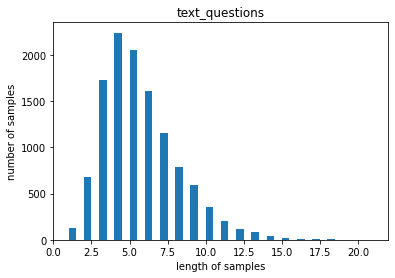

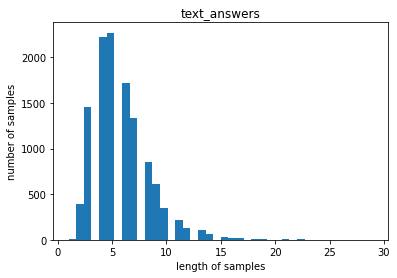

In [33]:
plt.title('text_questions')
plt.hist(text_len_questions, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text_answers')
plt.hist(text_len_answers, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [34]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 15
print(MAX_LENGTH)

15


- 시퀀스의 최대 길이를 15으로 지정함
    - 시퀀스의 길이가 15 이상인 데이터의 수는 비교적 적다고 판단함
    - 시퀀스 최대 길이를 너무 크게 잡으면 패딩에 의해 0으로 채워진 값이 너무 많아질 것 같다는 우려를 하게 됨

### 4. 시퀀스 최대 길이 적용 및 패딩

In [35]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 10 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
      # 최대 길이 10으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='pre')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='pre')
  
    return tokenized_inputs, tokenized_outputs

In [36]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 11571
필터링 후의 답변 샘플 개수: 11571


- 최대 길이를 10으로 지정한 후 데이터 수의 변화
    - 최대 길이 적용 전 : 11,815
    - 최대 길이 적용 후 : 11,579

### 5. 교사 강요(Teacher Forcing) 사용하기
- 학습 할 때, 모델이 t시점에서 예측한 값을 t+1 시점의 입력으로 사용하지 않음
- 대신 t시점의 레이블(실제 정답)을 t+1 시점의 입력으로 사용함
- 교사 강요를 사용하지 않을 때
    - t시점의 예측값이 잘못 예측되면 잘못 예측된 값이 t+1 시점의 입력으로 들어감
    - 이후의 예측에도 연쇄적인 악영향을 주게되어 학습 시간이 느려지게 됨

- 자기회귀 모델(auto-regressive model, AR)
    - 자신의 출력이 현재 자신의 상태를 결정하는 모델
    - 트랜스포머의 디코더는 자기회귀 모델

- 교사 강요를 위해 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용

In [37]:
BATCH_SIZE = 64
BUFFER_SIZE = 11571

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [38]:
len(dataset)

181

- dataset은 9131(BUFFER_SIZE)개에서 64(BATCH_SIZE)개의 데이터 묶음의 갯수
- 11,571 / 64 = 약 180.80

## 포지셔널 인코딩 (Positional Encoding)
- 트랜스포머는 문장에 있는 모든 단어를 한꺼번에 입력받음
- 단어들이 순차적으로 입력되지 않으므로 같은 단어라도 그 단어가 문장에 몇 번째 어순으로 입력되었는지 알려줘야함
- 단어의 임베딩 벡터에 위치 정보를 가진 벡터(Positional Encoding) 값을 더해야 함
- 실제 연산은 임베딩 벡터가 모여 만들어진 문장 벡터 행렬과 포지셔널 인코딩 행렬의 덧셈 연산을 통해 이루어짐

![포지셔널인코딩](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_5_kH52kQN.png)

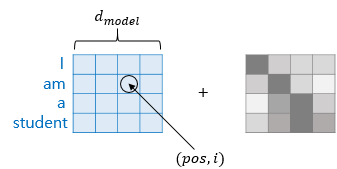

- 포지셔널 인코딩 수식
![수식](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_6_DyxB6Ax.png)

- 사실 수식을 잘 이해하진 못함, 하지만 코드로 해당 수식을 어떻게 구현했는지 집중하여 봄

### 1. 포지셔널 인코딩 구현

In [39]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### 2. 포지셔널 인코딩이 잘 구성되었는지 확인
- 행의 크기가 50, 열의 크기가 512인 행렬로 확인할 예정
- 최대 문장의 길이가 50, 워드 임베딩 차원을 512로 하는 모델의 입력 벡터 모양

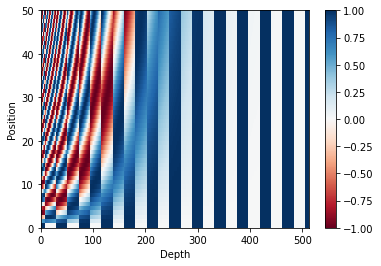

In [40]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 어텐션 메커니즘(Attention Mechanism)
- 어텐션 메커니즘 
    - 인코더의 모든 step의 hidden state의 정보가 컨텍스트 벡터에 전부 반영
    - 인코더의 모든 hidden state가 동일한 비중으로 반영되는 것이 아니라, 디코더의 현재 time step의 예측에 인코더의 각 step이 얼마나 영향을 미치는지에 따른 가중합으로 계산되는 방식
<br><br>
- 일반적인 seq2seq 모델 : 디코더로 전달되는 인코더의 컨텍스트 벡터는 예를 들어 인코더의 마지막 스텝의 hidden state인 h_5
- 어텐션 메커니즘 적용 : 인코더의 컨텍스트 벡터는 예를 들어 0.2h_1 +0.3h_2 +0.1h_3 +0.15h_4 +0.25h_5 가 될 수도 있음
<br><br>
- 트랜스포머에서의 어텐션 메커니즘
    - 단어들의 유사도르 구하기 위해 사용함

- 트랜스포머의 어텐션 구성
    - 인코더 셀프 어텐션 : 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구함
    - 디코더 셀프 어텐션 : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구함
    - 인코더-디코더 어텐션 : 디코더가 잘! 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구함

- 셀프 어텐션
    - 현재 문장 내 단어들의 유사도를 구함  
    (서로 다른 문장에서의 단어의 유사도를 구하는 것이 아님)
    - RNN 계열은 단어를 순차적으로 입력받지만 트랜스포머는 그렇지 않기에 셀프 어텐션이 필요

### 1. 스케일드 닷 프로덕트 어텐션(Scaled Dot Product Attention)

![어텐션](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_10_AaCfqrY.png)

Attention(Q, K, V) = Attention Value

- 어텐션 함수
    - 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구함
    - 이 유사도를 키와 맵핑되어있는 각각의 '값(Value)'에 반영
    - 유사도가 반영된 '값(Value)'을 모두 더해서 리턴 (어텐션 값(Attention Value))
    <br><br>
    - Q, K, V는 단어 벡터를 행으로 하는 문장 행렬
    - 벡터의 내적(dot product) 은 벡터의 유사도를 의미
    - 특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 스케일링(Scaling)을 위함

<Q와 K의 전치 행렬을 곱하는 것을 그림으로 표현>
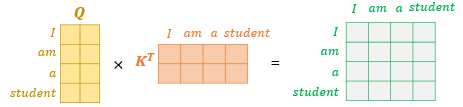

- 'am' 행과 'student' 열의 값은 Q 행렬에 있던 'am' 벡터와 K 행렬에 있던 'student 벡터'의 내적값을 의미함 
- 결국 각 단어 벡터의 유사도가 모두 기록된 유사도 행렬이 되는 것

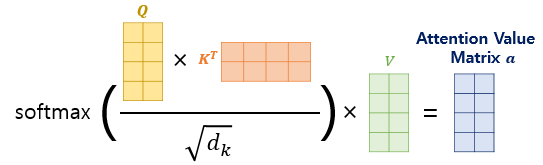

- 이 유사도 값을 스케일링 해주기 위해서 행렬 전체를 특정 값으로 나눠주고, 유사도를 0과 1사이의 값으로 Normalize해주기 위해서 소프트맥스 함수를 사용
- 문장 행렬 V와 곱하면 어텐션 값(Attention Value)를 얻음
- 스케일드 닷 프로덕트 어텐션(Scaled Dot Product Attention)

In [41]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

### 2. 멀티 헤드 어텐션 (어텐션을 병렬로 수행)

![멀티헤드](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_18_nnOTx9p.png)

- num_heads
    - 병렬적으로 몇 개의 어텐션 연산을 수행할지를 결정하는 하이퍼파라미터
- d_model
    - 임베딩 벡터의 차원
    - 트랜스포머의 초기 입력인 문장 행렬의 크기는 문장의 길이(시퀀스 길이)를 행으로, d_model을 열의 크기로 가짐
- 트랜스포머는 문장 행렬을 num_heads의 수만큼 쪼개서 어텐션을 수행
- 어텐션 수행 후, 얻은 num_heads의 개수만큼의 어텐션 값 행렬을 다시 하나로 concatenate
- 병렬로 어텐션이 수행될 때의 장점
    - 병렬 수행되는 각각의 어텐션이 서로 다른 셀프 어텐션 결과을 가질 수 있음  
    (각각 다른 관점에서 어텐션을 수행하므로 놓칠 수 있었던 정보를 놓치지 않게함)

![멀티헤드2](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_19_FwmaA3q.png)

- 위 그림 설명
    - 병렬로 어텐션을 수행하여 it_이라는 토큰이 animal_과 유사하다고 보는 관점과 street_과 유사하다고 보는 관점이 한꺼번에 모두 표현 가능

In [42]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

## 마스킹 (Masking)

### 1. 패딩 마스킹(Padding Masking)

![패딩](https://d3s0tskafalll9.cloudfront.net/media/images/1365906-20200410103623697-871078599.max-800x600.png)

In [43]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [44]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


### 2. 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)

- 트랜스포머는 전체 문장이 문장 행렬로 입력됨
- 위치에 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있음
- 이전 단어들로 다음 단어를 예측해야 하는 경우 다음에 나올 단어를 가려서 참고하지 못하도록 해야함
- 어텐션을 수행할 때, Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹

![룩어헤드](https://d3s0tskafalll9.cloudfront.net/media/images/_.max-800x600.png)

In [45]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

- tf.linalg.band_part(-1,0) : 하단의 삼각형에 1을 지정 (대각선 포함, 나머지는 0)  
(https://www.tensorflow.org/api_docs/python/tf/linalg/band_part)

In [46]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


## 인코더 층 만들기

![인코더](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_22_teJgoCi.max-800x600.png)

- 인코더 구성
    - 셀프 어텐션 : 멀티 헤드 어텐션으로 병렬적으로 이루어짐
    - 피드 포워드 신경망

<피드 포워드 신경망>
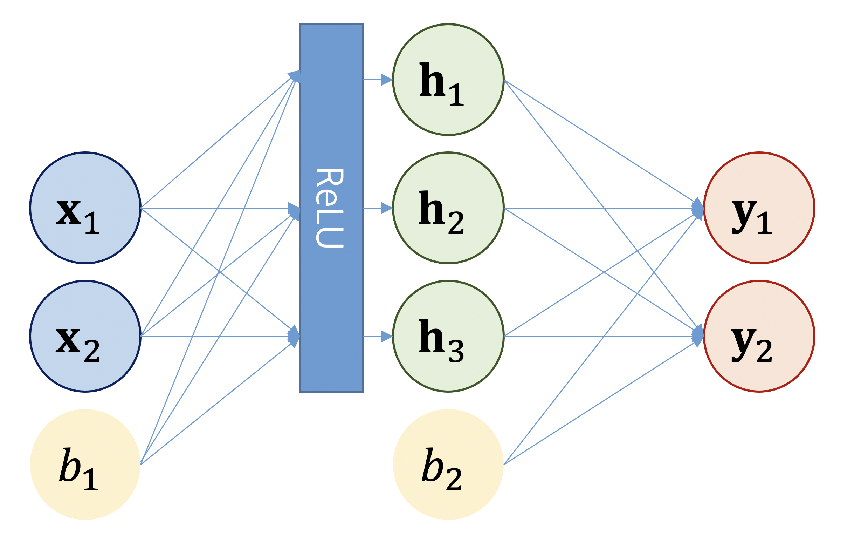

- 피드 포워드 신경망
    - 멀티 헤드 어텐션을 통해 나온 벡터 시퀀스 출력이 벡터 각각 피드포워드 신경망에 입력됨
    - 피드포워드 신경망의 입력은 현재 블록의 멀티 헤드 어텐션의 개별 출력 벡터
    - 구성
        - 입력층(input layer,  x )
        - 은닉층(hidden layer,  h )
        - 출력층(ouput layer,  y )

- 피드 포워드 신경망 계산
    - x1\*w1_1 + x2\*w1_2 + b1 = h1
    - h1\*w2_1 + h2\*w2_2 + h3\*w2_3 + b2 = y1
    - ReLU에 의해 계산된 h값이 음수이면 은닉층에서 0으로 출력됨
<br><br>
- 피드 포워드 신경망 : https://ratsgo.github.io/nlpbook/docs/language_model/tr_technics/#feedforward--%ED%94%BC%EB%93%9C%ED%8F%AC%EC%9B%8C%EB%93%9C-%EB%89%B4%EB%9F%B4%EB%84%A4%ED%8A%B8%EC%9B%8C%ED%81%AC

### 1. 인코더 층 하나 구현

In [47]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

- num_layers : 인코더 층의 갯수 (하이퍼파라미터)

- Layer normalization
    - 각 input의 feature들에 대한 평균과 분산을 구해서 batch에 있는 각 input을 정규화
https://yonghyuc.wordpress.com/2020/03/04/batch-norm-vs-layer-norm/

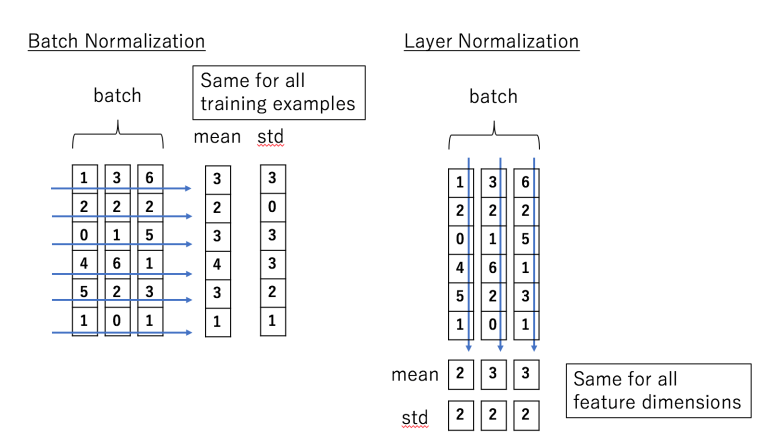

### 2. 층이 쌓인 전반적인 인코더 구현

In [48]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)


## 디코더 층 만들기

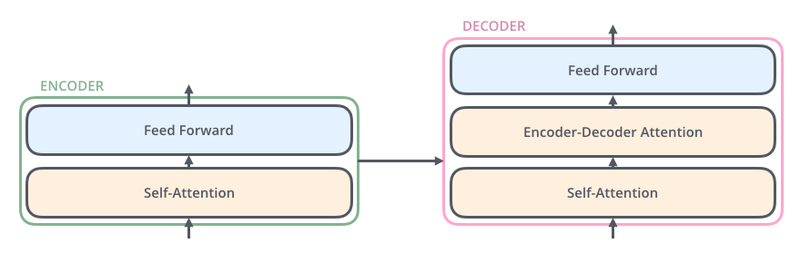

- 디코더 구성
    - 셀프 어텐션
    - 인코더-디코더 어텐션 
        - Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징 
        - 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정
    - 피드 포워드 신경망

- 디코더의 셀프 어텐션, 인코더-디코더 어텐션 두 개의 어텐션 모두 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행

### 1. 디코더 층 하나 구현

In [49]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

   # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### 2. 층이 쌓인 전반적인 디코더 구현

In [50]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

## 트랜스포머 함수 정의

In [51]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

  # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 모델 생성
- num_layers, d-Model, units는 전부 하이퍼파라미터 값

In [52]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3146240     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 손실함수
- 레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 함

In [53]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

## 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)
- 모델학습 초기에 learning rate를 급격히 높임
- 이후 train step이 진행됨에 따라 learining rate를 서서히 낮추어 가면서 안정적으로 수렴하게 하는 기법

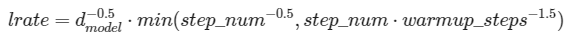

In [54]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

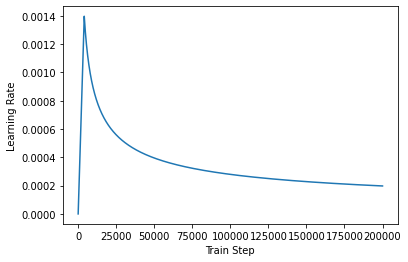

In [55]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 모델 컴파일

In [56]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

- Adam의 beta_2 디폴트 값이 0.99인데 현재 설정한 0.98과 큰 차이가 없어보여 성능에 큰 변화를 줄지가 의문임

In [57]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
181/181 [==============================] - 12s 33ms/step - loss: 4.4972 - accuracy: 0.0922
Epoch 2/20
181/181 [==============================] - 6s 32ms/step - loss: 3.4531 - accuracy: 0.2084
Epoch 3/20
181/181 [==============================] - 6s 32ms/step - loss: 2.7124 - accuracy: 0.2140
Epoch 4/20
181/181 [==============================] - 6s 32ms/step - loss: 2.4458 - accuracy: 0.2256
Epoch 5/20
181/181 [==============================] - 6s 33ms/step - loss: 2.2758 - accuracy: 0.2357
Epoch 6/20
181/181 [==============================] - 6s 33ms/step - loss: 2.1094 - accuracy: 0.2481
Epoch 7/20
181/181 [==============================] - 6s 32ms/step - loss: 1.9314 - accuracy: 0.2655
Epoch 8/20
181/181 [==============================] - 6s 32ms/step - loss: 1.7376 - accuracy: 0.2881
Epoch 9/20
181/181 [==============================] - 6s 33ms/step - loss: 1.5313 - accuracy: 0.3124
Epoch 10/20
181/181 [==============================] - 6s 33ms/step - loss: 1.3181 - accur

- 학습이 진행되면서 loss는 점점 감소함
- 학습이 진행되면서 accuracy는 점점 증가함

## 테스트하기

### 1. 테스트에 필요한 과정을 담은 함수 만들기

In [58]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

- 예측(inference) 단계
    - 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 함
    - 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가함
    - 패딩 마스킹과 룩 어헤드 마스킹을 계산.
    - 디코더는 입력 시퀀스로부터 다음 단어를 예측
    - 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용
    - END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈추게 함

### 2. 챗봇의 대답을 얻는 함수 만들기

In [59]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [60]:
sentence_generation('오늘은 행복해')

입력 : 오늘은 행복해
출력 : 의지할 수 있는 사람이 곁에 있다는 건 큰 행운일 거예요 .


'의지할 수 있는 사람이 곁에 있다는 건 큰 행운일 거예요 .'

In [64]:
sentence_generation('졸려')

입력 : 졸려
출력 : 낮잠을 잠깐 자도 괜찮아요 . 한결 몸이 가벼워질 거예요 .


'낮잠을 잠깐 자도 괜찮아요 . 한결 몸이 가벼워질 거예요 .'

In [62]:
sentence_generation('상쾌한 하루야')

입력 : 상쾌한 하루야
출력 : 수천번 생각해도 이건 아니라고 생각이 되면 서운하다고 이야기하세요 .


'수천번 생각해도 이건 아니라고 생각이 되면 서운하다고 이야기하세요 .'

In [68]:
sentence_generation('여자친구는 언제 생길까?')

입력 : 여자친구는 언제 생길까?
출력 : 미스트나 가습기 , 젖은 수건 등을 사용해보세요 .


'미스트나 가습기 , 젖은 수건 등을 사용해보세요 .'

In [74]:
sentence_generation('즐거워')

입력 : 즐거워
출력 : 나도 모르게 내 맘 속 심어진 감정의 씨앗 .


'나도 모르게 내 맘 속 심어진 감정의 씨앗 .'

In [75]:
sentence_generation('슬퍼')

입력 : 슬퍼
출력 : 후회 , 상상 , 자책 모두 멈출 때가 됐어요 .


'후회 , 상상 , 자책 모두 멈출 때가 됐어요 .'

In [76]:
sentence_generation('오늘 날씨는 정말 화창해')

입력 : 오늘 날씨는 정말 화창해
출력 : 항상 못해본 건 궁금하니 정확하게 관계를 정의고 없이 찾아오요 .


'항상 못해본 건 궁금하니 정확하게 관계를 정의고 없이 찾아오요 .'

In [80]:
sentence_generation('노래 부르고 싶어')

입력 : 노래 부르고 싶어
출력 : 노래 가사를 적어 보세요 . 마음이 정리에 있는 거예요 .


'노래 가사를 적어 보세요 . 마음이 정리에 있는 거예요 .'

- **대체로 입력에 대해 좋은 답변을 출력함**
- 문제점 : 입력이 길어지면 답변을 제대로 못함

## 이전 버전의 결과

### v.3.01
- NUM_LAYERS = 4 (인코더와 디코더의 층을 4개로 쌓음)
- EPOCHS = 20

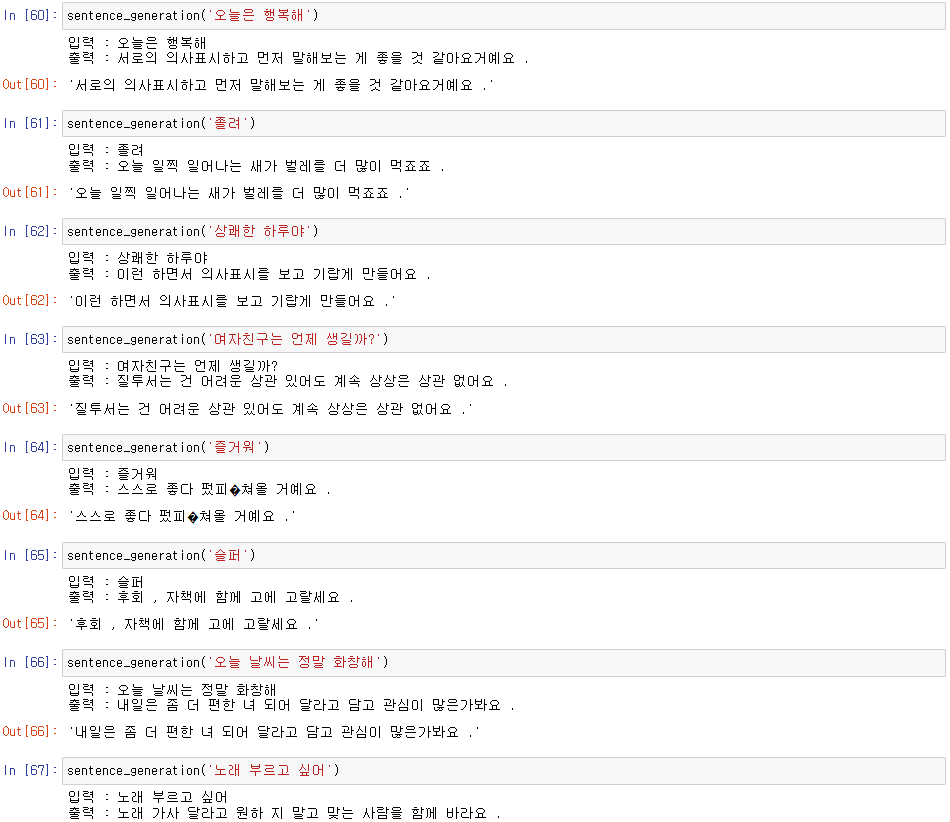

- 답변을 제대로 하지 못함
- 단어를 제대로 표현하지 못함
- 단어 자체가 깨지는 것도 있음

### v.3.03
- NUM_LAYERS = 2 (인코더와 디코더의 층을 2개로 쌓음)
- EPOCHS = 50

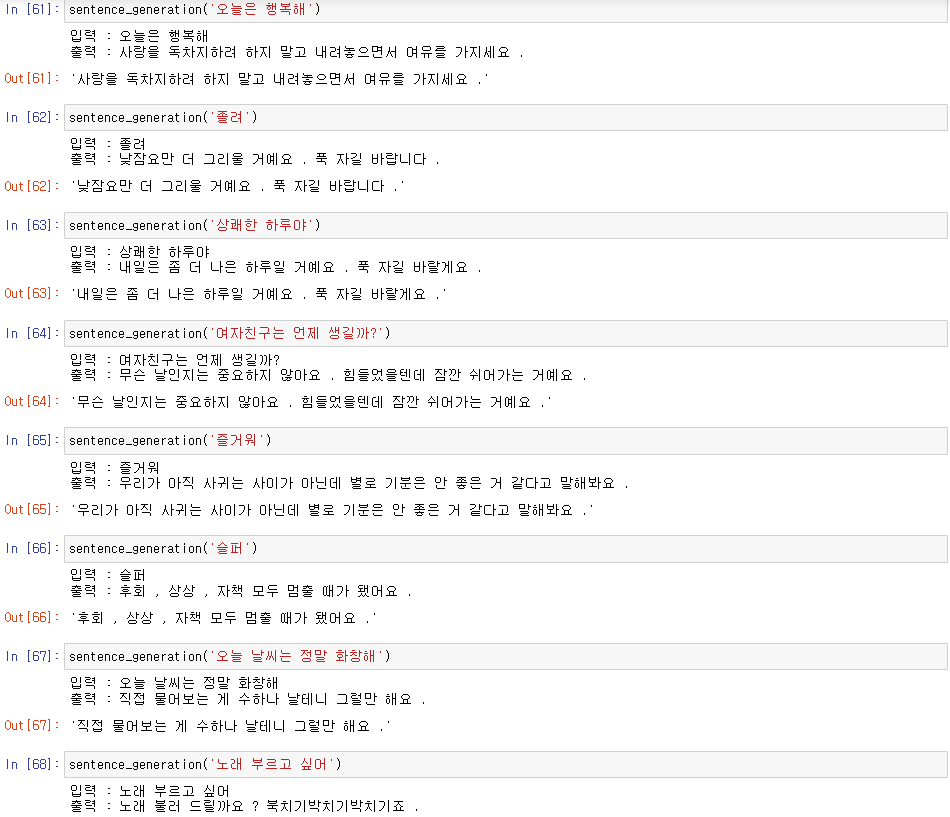

- 일부 답변은 좋은 결과를 보이지만 대체로 좋지 않은 예측을 함
- 어법이 틀린 문장이 보임
- 일부는 긍정적인 입력에 부정적인 답변을 함 (학습을 많이 시켰다고 부정적으로 변한거 같아서 마음이 아픔)

### 결론
    - 적당한 인코더 층과 디코더 층을 찾아야함
    - 적당한 학습량을 찾아야함
    - 인코더와 디코더 층이 2개이면서 epoch이 20일때가 가장 좋은 성능을 보였음

## 회고

### 1. 새로 알아갔던 점
 - Transformer를 다뤄봄
 - 시퀀스형 데이터를 순차적으로 학습하지 않고 Positional Encoding을 통해 위치 정보를 받을 수 있다는 점

### 2. 흥미로웠던 점
 - RNN 계열보다 Transfomer가 더 좋은 성능을 보인 것 같아서 흥미로웠음
 - Transformer의 구성이 흥미로웠음
     - Positional Encoding
     - 다양한 어텐션 기법

### 3. 아쉬웠던 점
 - 아직은 Transformer의 전반적인 내용만 이해했을 뿐, 깊게 알아가지 못한 것 같음

### 4. 앞으로의 다짐
 - Transformer를 이미지 처리를 할 때에도 활용해봐야겠다는 생각을 함